# 02 - Forecasting (Monthly Sales)

This notebook aggregates monthly sales and produces a 3-month forecast. It will try Prophet if available, otherwise a linear+seasonal fallback model will run.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sales = pd.read_csv('E:\Tutorials\Data Analyst\sales_ai_dashboard\data\sales_cleaned.csv', parse_dates=['date_parsed'])
# Aggregate monthly
sales['month_start'] = sales['date_parsed'].dt.to_period('M').dt.to_timestamp()
monthly = sales.groupby('month_start')['total_sale'].sum().reset_index().rename(columns={'month_start':'ds','total_sale':'y'})
monthly = monthly.sort_values('ds').reset_index(drop=True)
print(monthly.tail())


           ds           y
7  2024-08-01  114642.775
8  2024-09-01  106107.565
9  2024-10-01   93498.065
10 2024-11-01   84633.370
11 2024-12-01  100299.140


In [12]:
# Try Prophet model
try:
    from prophet import Prophet
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.fit(monthly)
    future = m.make_future_dataframe(periods=3, freq='M')
    forecast = m.predict(future)
    forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(3).to_csv('charts/monthly_sales_forecast_prophet.csv', index=False)
    print('Prophet forecast saved to charts/monthly_sales_forecast_prophet.csv')
    
    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(monthly['ds'], monthly['y'], label='historical')
    plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
    plt.fill_between(forecast['ds'].dt.to_pydatetime(), forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)
    plt.legend()
    plt.savefig('charts/forecast_monthly_prophet.png')
    plt.show()
except Exception as e:
    print('Prophet not available or failed:', e)


Prophet not available or failed: No module named 'prophet'


Linear seasonal forecast saved to charts/monthly_sales_forecast_linear.csv


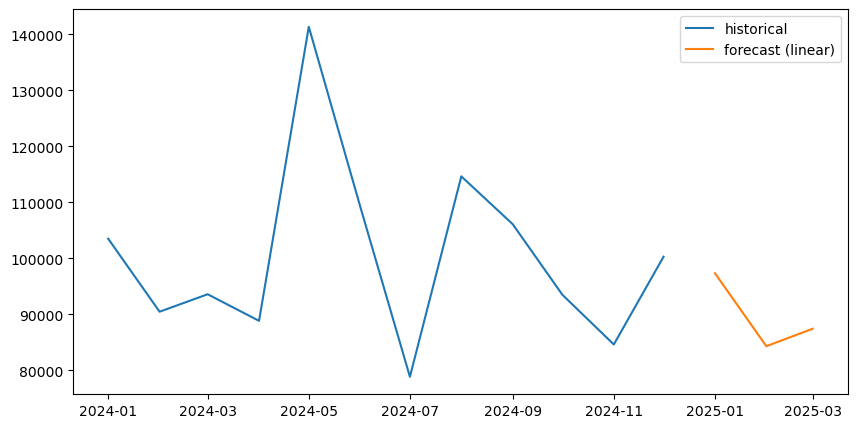

In [13]:
# Linear + seasonal fallback
from sklearn.linear_model import LinearRegression

df = monthly.copy()
df['t'] = np.arange(len(df))
df['month'] = df['ds'].dt.month
month_dummies = pd.get_dummies(df['month'], prefix='m', drop_first=True)
X = pd.concat([df[['t']], month_dummies], axis=1)
y = df['y']
model = LinearRegression()
model.fit(X, y)

# future
last_t = df['t'].iloc[-1]
future_ts = []
future_months = []
for i in range(1, 4):
    next_month = (df['ds'].iloc[-1] + pd.DateOffset(months=i)).to_period('M').to_timestamp()
    future_ts.append(last_t + i)
    future_months.append(next_month.month)
future_df = pd.DataFrame({'t': future_ts, 'month': future_months})
future_month_dummies = pd.get_dummies(future_df['month'], prefix='m', drop_first=True)
for col in X.columns[1:]:
    if col not in future_month_dummies.columns:
        future_month_dummies[col] = 0
future_X = pd.concat([future_df[['t']].reset_index(drop=True), future_month_dummies[X.columns[1:]]], axis=1)
preds = model.predict(future_X)
forecast_df = pd.DataFrame({'ds': [(df['ds'].iloc[-1] + pd.DateOffset(months=i)).to_period('M').to_timestamp() for i in range(1,4)], 'yhat': preds})
forecast_df.to_csv('charts/monthly_sales_forecast_linear.csv', index=False)
print('Linear seasonal forecast saved to charts/monthly_sales_forecast_linear.csv')

plt.figure(figsize=(10,5))
plt.plot(df['ds'], df['y'], label='historical')
plt.plot(forecast_df['ds'], forecast_df['yhat'], label='forecast (linear)')
plt.legend()
plt.savefig('charts/forecast_monthly_linear.png')
plt.show()
